In [ ]:
!pip install transformers tqdm pandas

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
wise_review = pd.read_csv("https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/wise_gstore_appstore.csv")

In [ ]:
Scores = wise_review['rating'].value_counts()
Scores

In [ ]:
Score_plot = Scores.sort_index().plot(kind = 'bar',
                         title = "Breakdown of Reviews by Score (5-Star Rating)",
                        figsize = (10,5))
Score_plot.set_xlabel('Review Score (Stars)')
plt.show()

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True
)

In [7]:
def distilbert_scores(text):
    output = sentiment_pipeline(text)
    scores = {item['label'].lower(): item['score'] for item in output[0]}
    return scores


In [8]:
from tqdm.auto import tqdm
tqdm.pandas()

reviews_df['sentiment_scores'] = reviews_df['review_description'].progress_apply(distilbert_scores)


  0%|          | 0/1095 [00:00<?, ?it/s]

In [9]:
sentiment_columns = reviews_df['sentiment_scores'].apply(pd.Series)
reviews_df = pd.concat([reviews_df, sentiment_columns], axis=1).drop('sentiment_scores', axis=1)

<ipython-input-20-ff00ab9b5458>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[i], x='rating', y=sentiment, data=reviews_df, ci=None)
<ipython-input-20-ff00ab9b5458>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[i], x='rating', y=sentiment, data=reviews_df, ci=None)
<ipython-input-20-ff00ab9b5458>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[i], x='rating', y=sentiment, data=reviews_df, ci=None)


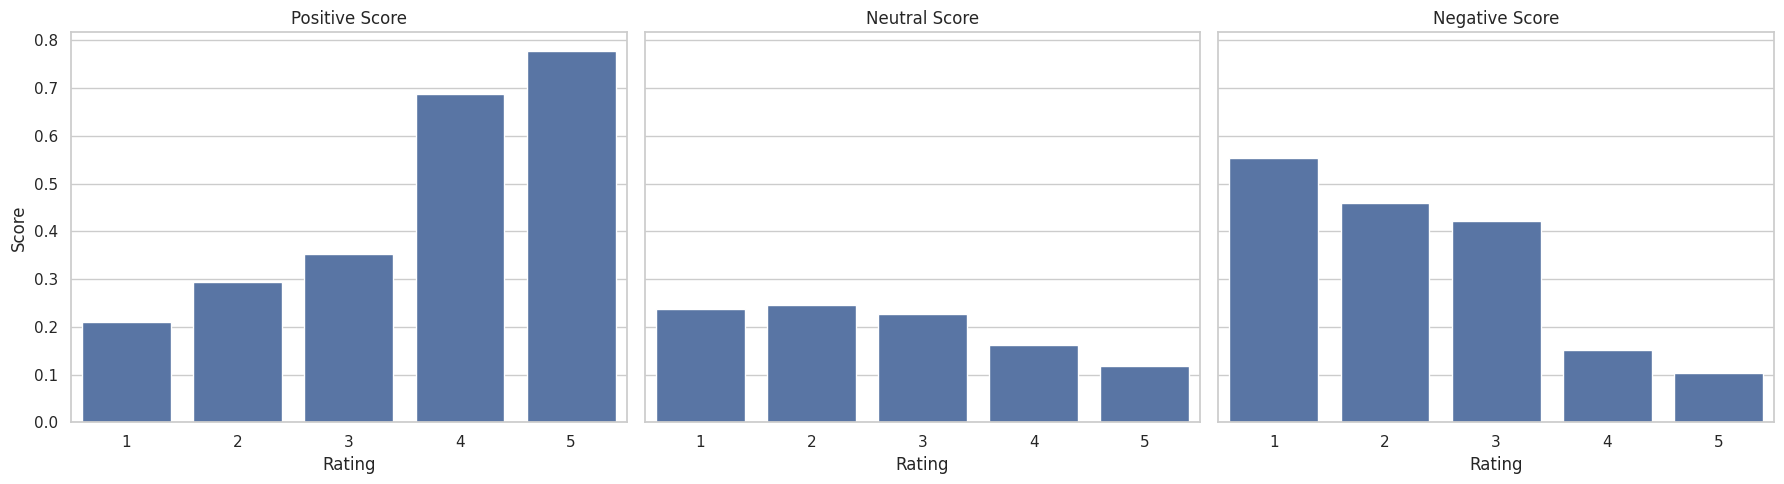

In [20]:
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    sns.barplot(ax=axes[i], x='rating', y=sentiment, data=reviews_df, ci=None)
    axes[i].set_title(f'{sentiment.capitalize()} Score')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Score')

plt.tight_layout()
plt.show()


In [33]:
import numpy as np

conditions = [
    (reviews_df['rating'] <= 2),
    (reviews_df['rating'] == 3),
    (reviews_df['rating'] >= 4)
]

values = ['Detractor', 'Passive', 'Promoter']

reviews_df['NPS_category'] = np.select(conditions, values)

# Calculate the percentage of Promoters, Passives, and Detractors
promoters_pct = (reviews_df['NPS_category'] == 'Promoter').mean()
passives_pct = (reviews_df['NPS_category'] == 'Passive').mean()
detractors_pct = (reviews_df['NPS_category'] == 'Detractor').mean()

# Calculate the NPS score
nps_score = (promoters_pct - detractors_pct) * 100

print(f'NPS Score: {nps_score:.2f}')
print(f'Promoter Percentage: {promoters_pct * 100:.2f}%')
print(f'Passive Percentage: {passives_pct * 100:.2f}%')
print(f'Detractor Percentage: {detractors_pct * 100:.2f}%')


NPS Score: 49.04
Promoter Percentage: 72.51%
Passive Percentage: 4.02%
Detractor Percentage: 23.47%


In [ ]:
reviews_df

<ipython-input-34-4b6b8c5b7aa7>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=nps_counts.index, y=nps_counts.values, palette='Dark2', orient='h')


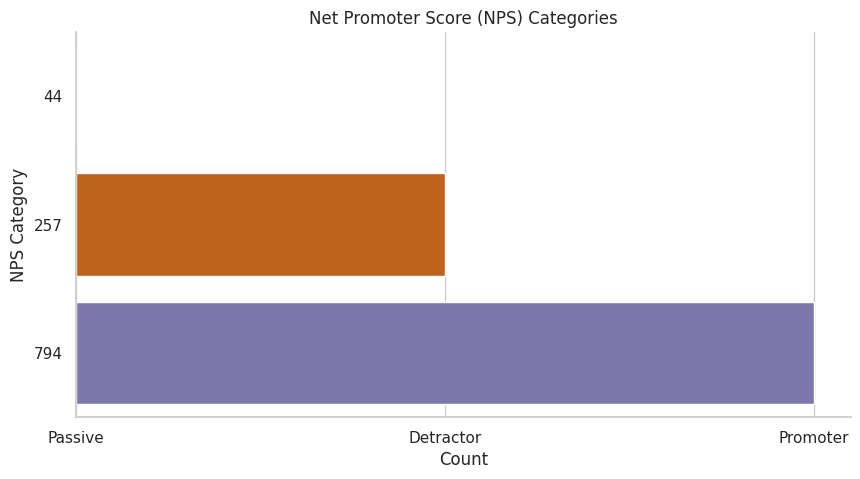

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

nps_counts = reviews_df['NPS_category'].value_counts()

nps_counts = nps_counts.reindex(['Promoter', 'Passive', 'Detractor'])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=nps_counts.index, y=nps_counts.values, palette='Dark2', orient='h')

plt.title('Net Promoter Score (NPS) Categories')
plt.xlabel('Count')
plt.ylabel('NPS Category')

sns.despine()

plt.show()


In [35]:
nps_res = reviews_df['NPS_category'].value_counts(normalize=True)

# Calculate the NPS Score
nps_score = (nps_res['Promoter'] - nps_res['Detractor']) * 100

# Print out the NPS Score and percentages for Promoters, Passives, and Detractors
print("NPS Score %:")
print(nps_score)
print("Promoter:", nps_res.get('Promoter', 0) * 100)
print("Passive:", nps_res.get('Passive', 0) * 100)
print("Detractor:", nps_res.get('Detractor', 0) * 100)

NPS Score %:
49.04109589041096
Promoter: 72.51141552511416
Passive: 4.018264840182648
Detractor: 23.470319634703195


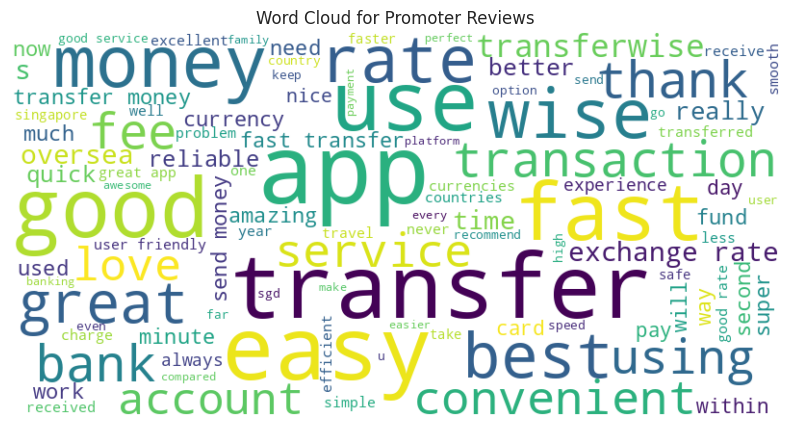

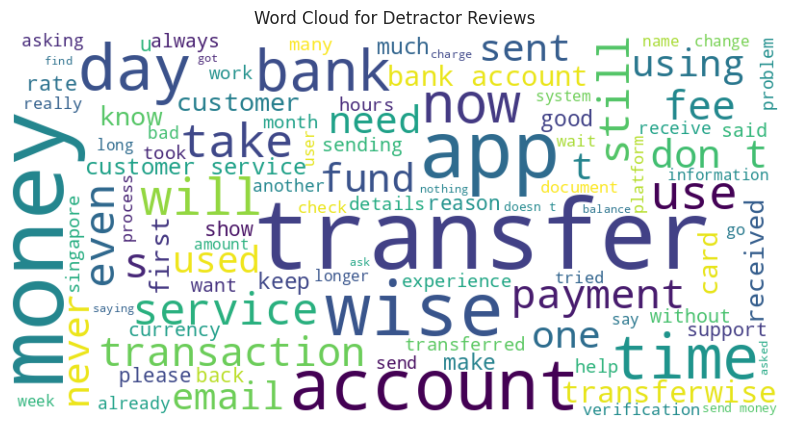

In [36]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

promoter_reviews = reviews_df['review_description'][reviews_df['NPS_category'] == 'Promoter']
detractor_reviews = reviews_df['review_description'][reviews_df['NPS_category'] == 'Detractor']

promoter_reviews_tokenized = ' '.join(review.lower() for review in promoter_reviews)
detractor_reviews_tokenized = ' '.join(review.lower() for review in detractor_reviews)

custom_stop_words = ['some', 'common', 'words', 'to', 'exclude']

stop_words = set(STOPWORDS.union(set(custom_stop_words)))

promoter_wordcloud = WordCloud(
    width=800, height=400,
    max_font_size=100, max_words=100,
    background_color='white', stopwords=stop_words
).generate(promoter_reviews_tokenized)

plt.figure(figsize=(10, 5))
plt.imshow(promoter_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Promoter Reviews')
plt.axis('off')
plt.show()

detractor_wordcloud = WordCloud(
    width=800, height=400,
    max_font_size=100, max_words=100,
    background_color='white', stopwords=stop_words
).generate(detractor_reviews_tokenized)

plt.figure(figsize=(10, 5))
plt.imshow(detractor_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Detractor Reviews')
plt.axis('off')
plt.show()


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words_to_remove = ['some', 'words', 'to', 'remove']
    querywords = text.split()
    resultwords  = [word for word in querywords if word.lower() not in words_to_remove]
    result = ' '.join(resultwords)
    return result

promoter_reviews_clean = [preprocess_text(review) for review in promoter_reviews]
detractor_reviews_clean = [preprocess_text(review) for review in detractor_reviews]

vectorizer = CountVectorizer(ngram_range=(2, 3))

promoter_counts = vectorizer.fit_transform(promoter_reviews_clean)
promoter_feature_names = vectorizer.get_feature_names_out()

detractor_counts = vectorizer.fit_transform(detractor_reviews_clean)
detractor_feature_names = vectorizer.get_feature_names_out()

promoter_counts_array = promoter_counts.toarray().sum(axis=0)
detractor_counts_array = detractor_counts.toarray().sum(axis=0)

promoter_ngrams = dict(zip(promoter_feature_names, promoter_counts_array))
detractor_ngrams = dict(zip(detractor_feature_names, detractor_counts_array))

print('Promoter N-grams:', list(promoter_ngrams.items()))
print('Detractor N-grams:', list(detractor_ngrams.items()))


Promoter N-grams: [('abit slower', 1), ('able attend', 1), ('able attend anymore', 1), ('able get', 1), ('able get my', 1), ('able hold', 1), ('able hold multiple', 1), ('able open', 1), ('able open multiple', 1), ('able remit', 1), ('able remit money', 1), ('able transfer', 1), ('able transfer within', 1), ('able use', 1), ('able use my', 1), ('able withdraw', 1), ('able withdraw money', 1), ('about being', 1), ('about being transparent', 1), ('about cheaper', 1), ('about cheaper compared', 1), ('about it', 1), ('about it edited', 1), ('about min', 1), ('about min even', 1), ('about mins', 1), ('about mins the', 1), ('about more', 1), ('about more than', 1), ('about my', 1), ('about my clothes', 1), ('about safety', 1), ('about safety dont', 1), ('about this', 3), ('about this app', 2), ('about this sooner', 1), ('abroad but', 1), ('abroad but the', 1), ('abroad extremely', 1), ('abroad extremely convenient', 1), ('abroad for', 1), ('abroad for lesser', 1), ('abroad with', 1), ('abroa

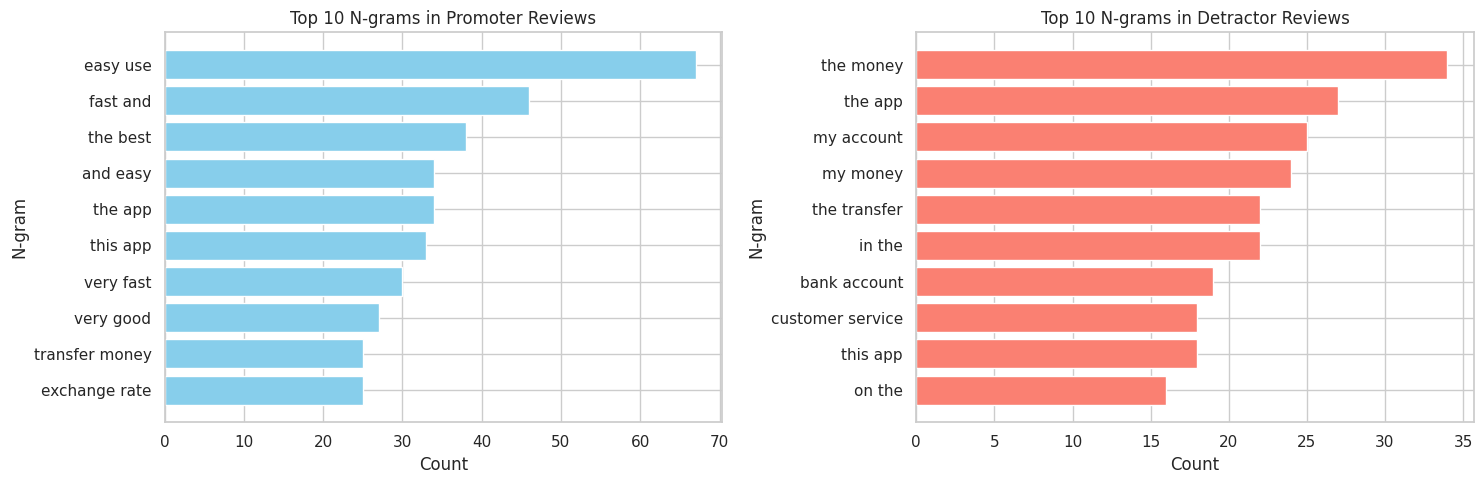

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

promoter_df = pd.DataFrame(list(promoter_ngrams.items()), columns=['N-gram', 'Count'])
detractor_df = pd.DataFrame(list(detractor_ngrams.items()), columns=['N-gram', 'Count'])

promoter_df = promoter_df.sort_values(by='Count', ascending=False).head(10)
detractor_df = detractor_df.sort_values(by='Count', ascending=False).head(10)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].barh(promoter_df['N-gram'][::-1], promoter_df['Count'][::-1], color='skyblue')
axs[0].set_title('Top 10 N-grams in Promoter Reviews')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('N-gram')

axs[1].barh(detractor_df['N-gram'][::-1], detractor_df['Count'][::-1], color='salmon')
axs[1].set_title('Top 10 N-grams in Detractor Reviews')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('N-gram')

plt.tight_layout()
plt.show()
